In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine

user = 'postgres'
password = '1711'
host = 'localhost'
port = '5432'
database = 'Full_Data'
schema = 'crypto'
table = 'binance_futures'
conn = f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}'                                           
engine = create_engine(conn)

query = f"SELECT * FROM {schema}.{table} WHERE ticker = '1000SATSUSDT'"
df = pd.read_sql(query, engine)
df.head()

,date,open,high,low,close,volume,ticker
0,2023-12-12 21:00:00,0.0005260,0.0005530,0.0005120,0.0005460,9248759734,1000SATSUSDT
1,2024-01-02 20:45:00,0.0008307,0.0008334,0.0008018,0.0008029,13673827586,1000SATSUSDT
2,2024-01-02 20:50:00,0.0008027,0.0008118,0.0008000,0.0008104,9361220475,1000SATSUSDT
3,2024-01-02 20:55:00,0.0008105,0.0008126,0.0008090,0.0008113,2216248995,1000SATSUSDT
4,2024-01-02 21:00:00,0.0008112,0.0008166,0.0008108,0.0008131,1968858202,1000SATSUSDT


In [18]:
df.set_index('date', inplace=True)

In [19]:
split = int(len(df) * 0.2)
train = df.iloc[:-split]
test = df.iloc[-split:]
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

Train shape: (55732, 6)
Test shape: (13933, 6)


In [20]:
train.head()

,open,high,low,close,volume,ticker
date,,,,,,
2023-12-12 21:00:00,0.0005260,0.0005530,0.0005120,0.0005460,9248759734,1000SATSUSDT
2024-01-02 20:45:00,0.0008307,0.0008334,0.0008018,0.0008029,13673827586,1000SATSUSDT
2024-01-02 20:50:00,0.0008027,0.0008118,0.0008000,0.0008104,9361220475,1000SATSUSDT
2024-01-02 20:55:00,0.0008105,0.0008126,0.0008090,0.0008113,2216248995,1000SATSUSDT
2024-01-02 21:00:00,0.0008112,0.0008166,0.0008108,0.0008131,1968858202,1000SATSUSDT


In [35]:
def calculate_alpha(df: pd.DataFrame, correlation_window: int = 10) -> pd.DataFrame:
    """
    Calculate the alpha using the formula:
    (-1 * correlation(rank(open), rank(volume), 10))
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing 'open' and 'volume' columns.
    correlation_window : int
        The window size for the rolling correlation. Default is 10.
        
    Returns:
    --------
    pd.DataFrame
        DataFrame with the calculated alpha values.
    """

    # Convert necessary columns to numeric (if not already) and handle any non-numeric data
    df['open'] = pd.to_numeric(df['open'], errors='coerce')
    df['volume'] = pd.to_numeric(df['volume'], errors='coerce')

    # 1. Rank the open prices
    df['rank_open'] = df['open'].rank()

    # 2. Rank the volume values
    df['rank_volume'] = df['volume'].rank()

    # 3. Calculate the 10-period rolling correlation
    df['correlation'] = df['rank_open'].rolling(window=correlation_window).corr(df['rank_volume'])

    # 4. Multiply the correlation by -1 to get the alpha
    df['alpha'] = -1 * df['correlation']

    # Clean up intermediate columns if needed
    df = df.drop(columns=['rank_open', 'rank_volume', 'correlation'])

    return df

<ipython-input-35-3e8086b631cd>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['open'] = pd.to_numeric(df['open'], errors='coerce')
<ipython-input-35-3e8086b631cd>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['volume'] = pd.to_numeric(df['volume'], errors='coerce')
<ipython-input-35-3e8086b631cd>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

<Axes: xlabel='date'>

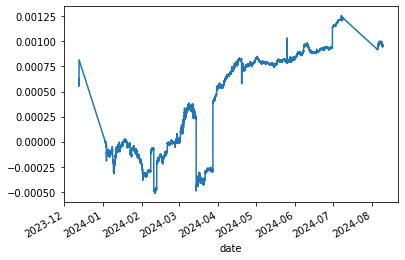

In [36]:
is_backtest = calculate_alpha(train)
is_backtest['pnl'] = is_backtest['close'].diff() * is_backtest['signal'].shift()
is_backtest.dropna(inplace=True)
is_backtest['pnl'].cumsum().plot()    

<ipython-input-35-3e8086b631cd>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['open'] = pd.to_numeric(df['open'], errors='coerce')
<ipython-input-35-3e8086b631cd>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['volume'] = pd.to_numeric(df['volume'], errors='coerce')
<ipython-input-35-3e8086b631cd>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

<Axes: xlabel='date'>

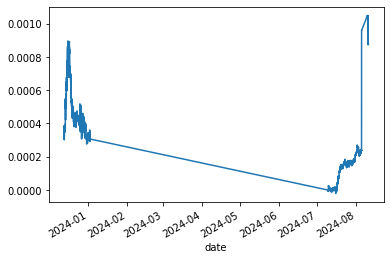

In [37]:
is_backtest = calculate_alpha(test)
is_backtest['pnl'] = is_backtest['close'].diff() * is_backtest['signal'].shift()
is_backtest.dropna(inplace=True)
is_backtest['pnl'].cumsum().plot()    